# Trabalho Final - Processamento de Imagens

Alunos: Lais Vitória Batista Santos e
Tiago Rodrigues dos Santos

In [38]:
from skimage.data import coins
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.transform import resize, hough_circle_peaks, hough_circle, hough_ellipse
from skimage.draw import ellipse_perimeter
import numpy as np
from scipy.ndimage import gaussian_filter, label
from skimage.filters import sobel, threshold_otsu
from skimage.morphology import (
    opening,
    binary_opening,
    binary_closing,
    binary_erosion,
    footprint_rectangle
)
from skimage import color
from skimage.draw import circle_perimeter
from glob import glob
from skimage.color import gray2rgb
import math

## Funções importantes criadas

In [18]:
def my_threshold_otsu(image, nbins=256):
    # achata a imagem
    img = image.ravel()

    # histograma
    hist, bin_edges = np.histogram(img, bins=nbins)

    # probabilidade de cada nível
    hist = hist.astype(float)
    prob = hist / hist.sum()

    # centros dos bins
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # pesos acumulados
    w0 = np.cumsum(prob)
    w1 = 1.0 - w0

    # médias acumuladas
    mu0 = np.cumsum(prob * bin_centers) / np.maximum(w0, 1e-10)
    muT = np.sum(prob * bin_centers)
    mu1 = (muT - w0 * mu0) / np.maximum(w1, 1e-10)

    # variância entre classes
    sigma_b2 = w0 * w1 * (mu0 - mu1) ** 2

    # threshold ótimo
    idx = np.argmax(sigma_b2)
    return bin_centers[idx]

def my_gray2rgb(img):
    if img.ndim != 2:
        raise ValueError("A imagem deve ser 2D (grayscale)")

    return np.stack([img, img, img], axis=-1)

def my_circle_perimeter(cy, cx, r, shape=None):
    rr, cc = [], []

    x = r
    y = 0
    p = 1 - r

    while x >= y:
        points = [
            ( cy + y, cx + x),
            ( cy + y, cx - x),
            ( cy - y, cx + x),
            ( cy - y, cx - x),
            ( cy + x, cx + y),
            ( cy + x, cx - y),
            ( cy - x, cx + y),
            ( cy - x, cx - y),
        ]
        for py, px in points:
            rr.append(py)
            cc.append(px)

        y += 1
        if p <= 0:
            p += 2*y + 1
        else:
            x -= 1
            p += 2*y - 2*x + 1

    rr = np.array(rr)
    cc = np.array(cc)

    if shape is not None:
        h, w = shape[:2]
        mask = (rr >= 0) & (rr < h) & (cc >= 0) & (cc < w)
        rr, cc = rr[mask], cc[mask]

    return rr, cc

def my_label(binary_img):
    h, w = binary_img.shape
    labels = np.zeros((h, w), dtype=int)

    label_id = 0

    for y in range(h):
        for x in range(w):
            if binary_img[y, x] and labels[y, x] == 0:
                label_id += 1
                stack = [(y, x)]
                labels[y, x] = label_id

                while stack:
                    cy, cx = stack.pop()

                    for ny, nx in [
                        (cy-1, cx), (cy+1, cx),
                        (cy, cx-1), (cy, cx+1),
                        (cy-1, cx-1), (cy-1, cx+1),
                        (cy+1, cx-1), (cy+1, cx+1)
                    ]:
                        if (0 <= ny < h and 0 <= nx < w and
                            binary_img[ny, nx] and labels[ny, nx] == 0):
                            labels[ny, nx] = label_id
                            stack.append((ny, nx))

    return labels, label_id

## Função de pré-processamento

In [19]:
def preprocessar(img):
    # Etapas comuns
    img_smooth = gaussian_filter(img, sigma=2)
    edges = sobel(img_smooth)
    th = my_threshold_otsu(edges)
    bin_edges = edges > th

    # Métricas
    densidade = np.mean(bin_edges)
    num_componentes = my_label(bin_edges)[1]

    # Decisão
    tem_ruido = (densidade > 0.02) or (num_componentes > 300)

    if tem_ruido:
        # Limpeza pesada
        fp_open = np.ones((5, 5)).astype('uint8')
        fp_close = np.ones((3, 9)).astype('uint8')
        fp_erode = np.ones((2, 2)).astype('uint8')

        bin_edges = binary_opening(bin_edges, fp_open)
        bin_edges = binary_closing(bin_edges, fp_close)
        bin_edges = binary_erosion(bin_edges, fp_erode)

    return bin_edges, {
        "densidade": densidade,
        "componentes": num_componentes,
        "ruido_aplicado": tem_ruido
    }

## Função de detecção de círculos

In [20]:
def detectar_circulo(img_bin, raios):
    hough_res = hough_circle(img_bin, raios)

    accs, cx, cy, r = hough_circle_peaks(
        hough_res,
        raios,
        total_num_peaks=1
    )

    if len(r) == 0:
        return None

    return cx[0], cy[0], r[0]

## Ler imagens da pasta

In [21]:
paths = sorted(glob('*images/*'))
print(paths)

['images/16.jpg', 'images/31.jpg', 'images/4.jpg', 'images/40.jpg', 'images/49.jpg', 'images/69.jpg', 'images/79.jpg']


## Detectar círculos nas imagens

In [46]:
i

6

[██████████████████████████████] 100.00%

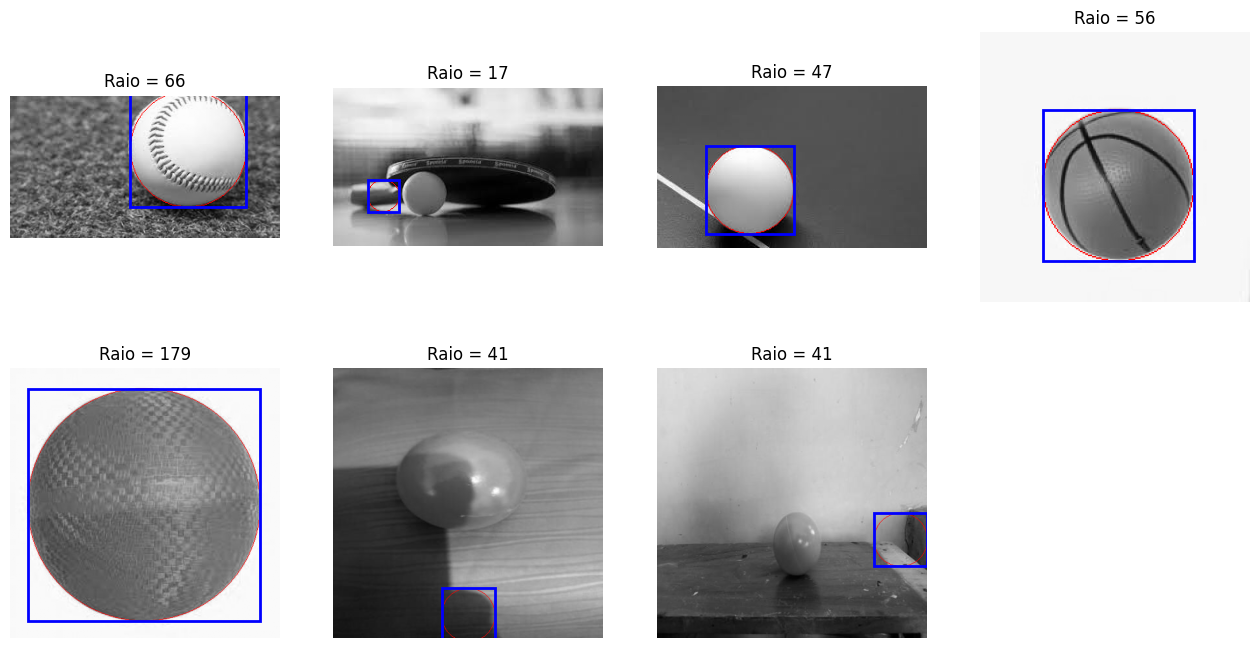

In [53]:
resultados_hough = []
n = len(paths)
cols = 4
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.flatten()
for i, path in enumerate(paths):
  img = imread(path, as_gray=True)

  img_bin, info = preprocessar(img)

  h, w = img.shape
  raios = np.arange(
      int(min(h, w) * 0.1),
      int(min(h, w) * 0.8),
      2
  )

  resultado = detectar_circulo(img_bin, raios)

  if resultado is None:
      print(f'Nenhum círculo encontrado em {path}')
      continue

  cx, cy, r = resultado

  # guarda resultado
  h, w = img.shape
  resultados_hough.append({
      "key": path.split('/')[-1], #nome da imagem
      "h": h, # altura da imagem
      "w": w, # largura da imagem
      "cx": cx, # coordenada x do centro do círculo
      "cy": cy, # coordenada y do centro do círculo
      "r": r # raio do círculo
  })

  # Visualização
  img_color = my_gray2rgb(img)
  rr, cc = my_circle_perimeter(cy, cx, r, shape=img.shape)
  img_color[rr, cc] = (1, 0, 0)

  axes[i].set_title(f'Raio = {r}')

  # Bounding box
  x_min = int(cx - r)
  y_min = int(cy - r)
  x_max = int(cx + r)
  y_max = int(cy + r)

  axes[i].imshow(img_color)

  rect = Rectangle(
      (x_min, y_min),
      x_max - x_min,
      y_max - y_min,
      edgecolor='blue',
      facecolor='none',
      linewidth=2
  )

  axes[i].add_patch(rect)
  axes[i].axis('off')

  progress = (i + 1) / n
  bar_len = 30
  filled = int(bar_len * progress)
  bar = '█' * filled + '-' * (bar_len - filled)
  print(f'\r[{bar}] {100*progress:6.2f}%', end='')

# Remove eixos vazios
for ax in axes[n:]:
    ax.axis('off')
plt.show()

## Medindo a eficiência do algoritmo

### Lista com valores já conhecidos dos centros e tamanhos dos círculos das imagens (Disponível no roboflow)

In [24]:
valores_conhecidos = np.array([
    {
      "boxes": [
          {
              "label": "bola",
              "x": 97,
              "y": 110.5,
              "width": 94,
              "height": 95
          }
      ],
      "height": 174,
      "key": "4.jpg",
      "width": 289
    },
    {
      "boxes": [
          {
              "label": "bola",
              "x": 203,
              "y": 64.5,
              "width": 136,
              "height": 127
          }
      ],
      "height": 163,
      "key": "16.jpg",
      "width": 308
    },
    {
      "boxes": [
          {
              "label": "bola",
              "x": 98.5,
              "y": 115,
              "width": 51,
              "height": 50
          }
      ],
      "height": 172,
      "key": "31.jpg",
      "width": 292
    },
    {
      "boxes": [
          {
              "label": "bola",
              "x": 103.5,
              "y": 111.5,
              "width": 115,
              "height": 115
          }
      ],
      "height": 200,
      "key": "40.jpg",
      "width": 200
    },
    {
      "boxes": [
          {
              "label": "bola",
              "x": 112,
              "y": 114.5,
              "width": 196,
              "height": 197
          }
      ],
      "height": 225,
      "key": "49.jpg",
      "width": 225
    },
    {
      "boxes": [
          {
              "label": "bola",
              "x": 308,
              "y": 267.5,
              "width": 323.5,
              "height": 253
          }
      ],
      "height": 640,
      "key": "69.jpg",
      "width": 640
    },
    {
      "boxes": [
          {
              "label": "bola",
              "x": 2075,
              "y": 1941,
              "width": 762,
              "height": 758
          }
      ],
      "height": 3000,
      "key": "79.jpg",
      "width": 4000
    },
])

### Calculando erros e acertos

In [25]:
# listas para armazenar erros
erros_centro = []
erros_raio = []

# critério de acerto
THRESHOLD_CENTRO = 10   # pixels
THRESHOLD_RAIO = 10    # pixels

acertos = 0
total = 0

valores_por_key = {elem['key']: elem for elem in valores_conhecidos}

for resultado_hough in resultados_hough:
    key = resultado_hough['key']

    if key not in valores_por_key:
        continue

    total += 1
    # encontrar correspondente
    valor_conhecido = valores_por_key[key]

    escala_x = resultado_hough['w'] / valor_conhecido['width']
    escala_y = resultado_hough['h'] / valor_conhecido['height']

    # alterar valores conforme a escala
    valor_conhecido_cx = valor_conhecido['boxes'][0]['x'] * escala_x
    valor_conhecido_cy = valor_conhecido['boxes'][0]['y'] * escala_y

    # como é um círculo, usamos metade da largura como raio
    valor_conhecido_r = (valor_conhecido['boxes'][0]['width'] / 2) * escala_x

    # resultado do Hough
    h_cx = resultado_hough['cx']
    h_cy = resultado_hough['cy']
    h_r  = resultado_hough['r']

    # erro euclidiano do centro
    erro_centro = np.sqrt((h_cx - valor_conhecido_cx)**2 + (h_cy - valor_conhecido_cy)**2)

    # erro absoluto do raio
    erro_raio = abs(h_r - valor_conhecido_r)

    erros_centro.append(erro_centro)
    erros_raio.append(erro_raio)

    # define acerto
    if erro_centro <= THRESHOLD_CENTRO and erro_raio <= THRESHOLD_RAIO:
        acertos += 1

### Mostrar eficiência

In [29]:
porcentagem_acerto = (acertos / total) * 100
porcentagem_erro = 100 - porcentagem_acerto
erros = total - acertos
print(f"Total de imagens avaliadas: {total}")
print(f"Acertos: {acertos}")
print(f"Erro: {erros}")
print(f"Taxa de acerto: {porcentagem_acerto:.2f}%")
print(f"Taxa de erro: {porcentagem_erro:.2f}%")

print("\nErros médios:")
print(f"  Erro médio do centro: {np.mean(erros_centro):.2f} pixels")
print(f"  Erro médio do raio: {np.mean(erros_raio):.2f} pixels")

Total de imagens avaliadas: 7
Acertos: 4
Erro: 3
Taxa de acerto: 57.14%
Taxa de erro: 42.86%

Erros médios:
  Erro médio do centro: 59.97 pixels
  Erro médio do raio: 11.39 pixels


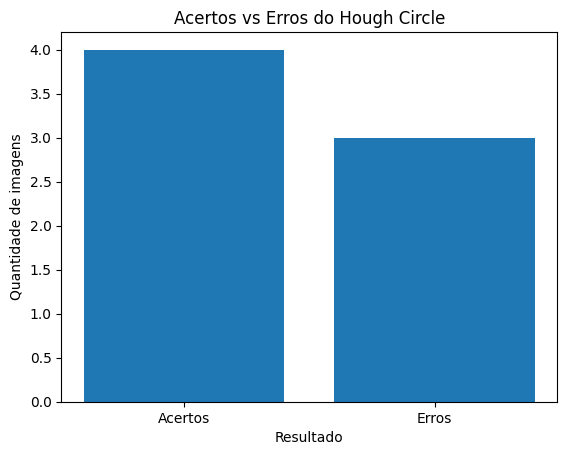

In [30]:
plt.figure()
plt.bar(['Acertos', 'Erros'], [acertos, erros])
plt.title('Acertos vs Erros do Hough Circle')
plt.ylabel('Quantidade de imagens')
plt.xlabel('Resultado')
plt.show()

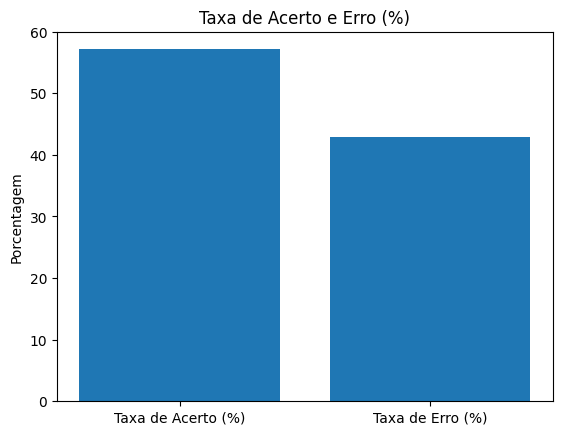

In [33]:
plt.figure()
plt.bar(['Taxa de Acerto (%)', 'Taxa de Erro (%)'],
        [porcentagem_acerto, porcentagem_erro])
plt.title('Taxa de Acerto e Erro (%)')
plt.ylabel('Porcentagem')
plt.show()